## K-means to segment customer based on RFM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('Onlineretail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313.0,United Kingdom
1,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom
2,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom
3,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313.0,United Kingdom
4,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313.0,United Kingdom


In [3]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,203422.000000,203422.000000,150039.000000
mean,9.585684,4.877820,15240.234832
std,240.921315,113.686676,1717.658493
min,-74215.000000,0.000000,12346.000000
25%,1.000000,1.250000,13791.000000
50%,3.000000,2.100000,15061.000000
75%,10.000000,4.130000,16771.000000
max,74215.000000,38970.000000,18287.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203422 entries, 0 to 203421
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    203422 non-null  object 
 1   StockCode    203422 non-null  object 
 2   Description  202623 non-null  object 
 3   Quantity     203422 non-null  int64  
 4   InvoiceDate  203422 non-null  object 
 5   UnitPrice    203422 non-null  float64
 6   CustomerID   150039 non-null  float64
 7   Country      203422 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 12.4+ MB


In [5]:
df.isnull().sum()

InvoiceNo          0
StockCode          0
Description      799
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     53383
Country            0
dtype: int64

In [6]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [7]:
df['InvoiceDate'].head()

0   2011-01-04 10:00:00
1   2011-01-04 10:00:00
2   2011-01-04 10:00:00
3   2011-01-04 10:00:00
4   2011-01-04 10:00:00
Name: InvoiceDate, dtype: datetime64[ns]

In [8]:
df['InvoiceDate'].tail()

203417   2011-06-30 20:08:00
203418   2011-06-30 20:08:00
203419   2011-06-30 20:08:00
203420   2011-06-30 20:08:00
203421   2011-06-30 20:08:00
Name: InvoiceDate, dtype: datetime64[ns]

In [9]:
print(df['InvoiceDate'].max(), df['InvoiceDate'].min())

2011-06-30 20:08:00 2011-01-04 10:00:00


In [10]:
df_rfm = df.drop(columns=['Description',"Country", 'StockCode'])
df_rfm.columns

Index(['InvoiceNo', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID'], dtype='object')

In [11]:
df_rfm = df_rfm[df_rfm['Quantity']>0]
df_rfm = df_rfm[df_rfm['UnitPrice']>0]
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198451 entries, 0 to 203421
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    198451 non-null  object        
 1   Quantity     198451 non-null  int64         
 2   InvoiceDate  198451 non-null  datetime64[ns]
 3   UnitPrice    198451 non-null  float64       
 4   CustomerID   146478 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 9.1+ MB


In [12]:
df_rfm.isnull().sum()

InvoiceNo          0
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     51973
dtype: int64

In [13]:
df_rfm.dropna(inplace=True)
df_rfm = df_rfm.drop_duplicates()
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92374 entries, 0 to 203398
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    92374 non-null  object        
 1   Quantity     92374 non-null  int64         
 2   InvoiceDate  92374 non-null  datetime64[ns]
 3   UnitPrice    92374 non-null  float64       
 4   CustomerID   92374 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 4.2+ MB


In [14]:
df_rfm

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID
0,539993,10,2011-01-04 10:00:00,1.95,13313.0
1,539993,25,2011-01-04 10:00:00,0.42,13313.0
3,539993,5,2011-01-04 10:00:00,2.10,13313.0
4,539993,10,2011-01-04 10:00:00,1.25,13313.0
6,539993,6,2011-01-04 10:00:00,3.25,13313.0
...,...,...,...,...,...
203392,558637,1,2011-06-30 20:08:00,1.25,17891.0
203393,558637,1,2011-06-30 20:08:00,2.95,17891.0
203395,558637,1,2011-06-30 20:08:00,2.10,17891.0
203396,558637,12,2011-06-30 20:08:00,0.85,17891.0


In [15]:
df_rfm['Cost'] = df_rfm["Quantity"]*df_rfm['UnitPrice']
df_rfm.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Cost
0,539993,10,2011-01-04 10:00:00,1.95,13313.0,19.5
1,539993,25,2011-01-04 10:00:00,0.42,13313.0,10.5
3,539993,5,2011-01-04 10:00:00,2.10,13313.0,10.5
4,539993,10,2011-01-04 10:00:00,1.25,13313.0,12.5
6,539993,6,2011-01-04 10:00:00,3.25,13313.0,19.5


In [16]:
df_invoice = df_rfm[['InvoiceNo',"Cost"]].groupby('InvoiceNo').sum()
df_invoice.head()

,Cost
InvoiceNo,
539993,211.30
540001,454.50
540002,310.28
540003,198.05
540004,76.32


In [17]:
#df_rfm['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Kiểm tra kiểu dữ liệu của cột InvoiceDate
print(df_rfm['InvoiceDate'].dtype)

datetime64[ns]


In [18]:
df_rfm.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Cost
0,539993,10,2011-01-04 10:00:00,1.95,13313.0,19.5
1,539993,25,2011-01-04 10:00:00,0.42,13313.0,10.5
3,539993,5,2011-01-04 10:00:00,2.10,13313.0,10.5
4,539993,10,2011-01-04 10:00:00,1.25,13313.0,12.5
6,539993,6,2011-01-04 10:00:00,3.25,13313.0,19.5


In [19]:
df_rfm.tail()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Cost
203392,558637,1,2011-06-30 20:08:00,1.25,17891.0,1.25
203393,558637,1,2011-06-30 20:08:00,2.95,17891.0,2.95
203395,558637,1,2011-06-30 20:08:00,2.10,17891.0,2.10
203396,558637,12,2011-06-30 20:08:00,0.85,17891.0,10.20
203398,558637,20,2011-06-30 20:08:00,0.65,17891.0,13.00


In [20]:
now = df_rfm['InvoiceDate'].max() 
now - df_rfm['InvoiceDate'][0]

Timedelta('177 days 10:08:00')

In [21]:
print(now)

2011-06-30 20:08:00


In [22]:
#RFM
df_rfm['Recency'] = (now - df_rfm['InvoiceDate']).dt.days
df_rfm.drop(columns='InvoiceDate', inplace=True)
df_rfm.head()

,InvoiceNo,Quantity,UnitPrice,CustomerID,Cost,Recency
0,539993,10,1.95,13313.0,19.5,177
1,539993,25,0.42,13313.0,10.5,177
3,539993,5,2.10,13313.0,10.5,177
4,539993,10,1.25,13313.0,12.5,177
6,539993,6,3.25,13313.0,19.5,177


In [23]:
df_rfm = df_rfm[['InvoiceNo','CustomerID','Cost','Recency']]
rfm = df_rfm.groupby('CustomerID').aggregate({'InvoiceNo':'nunique',
                                        'Cost':'sum',
                                        'Recency':'min'})
rfm.head()

,InvoiceNo,Cost,Recency
CustomerID,,,
12346.0,1,77183.60,163
12347.0,3,1049.46,21
12348.0,2,469.16,86
12350.0,1,174.20,148
12352.0,5,1455.86,100


In [24]:
rfm.columns = ['Frequency','Monetary', "Recency"]
rfm = rfm[["Recency",'Frequency','Monetary']]
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,163,1,77183.60
12347.0,21,3,1049.46
12348.0,86,2,469.16
12350.0,148,1,174.20
12352.0,100,5,1455.86


In [25]:
rfm.describe()

,Recency,Frequency,Monetary
count,2724.000000,2724.000000,2724.000000
mean,59.764684,2.717327,939.536814
std,47.913115,3.878259,3589.578865
min,0.000000,1.000000,2.900000
25%,20.000000,1.000000,180.550000
50%,46.000000,2.000000,355.135000
75%,94.000000,3.000000,761.657500
max,177.000000,67.000000,89361.990000


c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


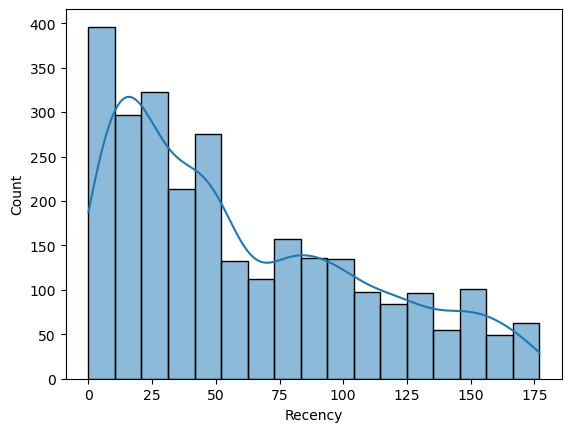

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(rfm['Recency'], kde=True)
plt.show()


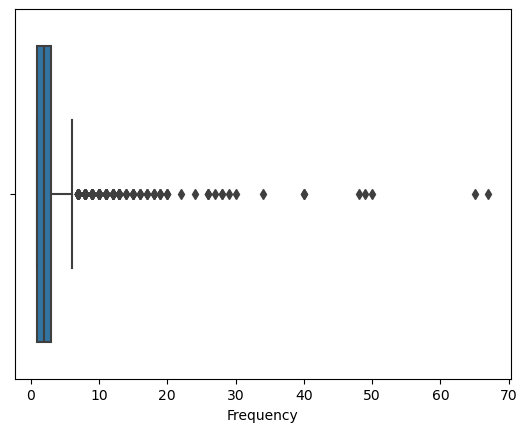

In [27]:
sns.boxplot(x=rfm['Frequency'])
plt.show()

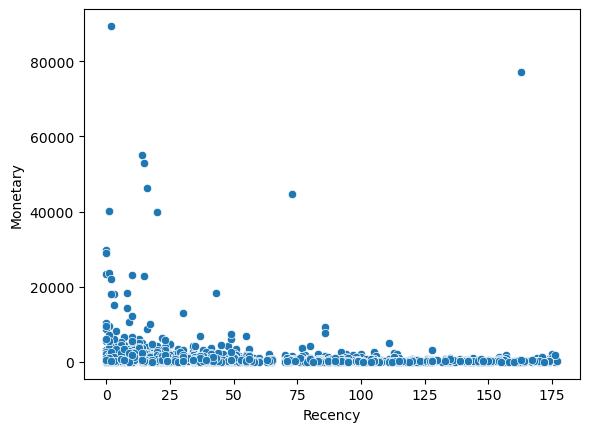

In [28]:
sns.scatterplot(x='Recency', y='Monetary', data=rfm)
plt.show()

In [32]:
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,163,1,77183.60
12347.0,21,3,1049.46
12348.0,86,2,469.16
12350.0,148,1,174.20
12352.0,100,5,1455.86


In [36]:
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,163,1,77183.60
12347.0,21,3,1049.46
12348.0,86,2,469.16
12350.0,148,1,174.20
12352.0,100,5,1455.86
...,...,...,...
18273.0,95,1,51.00
18280.0,115,1,147.90
18281.0,18,1,53.79


### **Chuẩn hóa dữ liệu**
+ Dữ liệu cần chuẩn hóa chỉ bao gồm các đặc trưng số học có ý nghĩa phân cụm: Cost, Recency.

+ Sử dụng StandardScaler để chuẩn hóa dữ liệu (mean = 0, std = 1).

In [39]:
rfm.columns

Index(['Recency', 'Frequency', 'Monetary'], dtype='object')

In [40]:
#rfm = rfm.set_index("CustomerID")

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm)

In [41]:
X_scaled

array([[ 2.15503145, -0.44289021, 21.24429209],
       [-0.80921062,  0.07289984,  0.03062849],
       [ 0.54766075, -0.18499519, -0.13106361],
       ...,
       [-0.87183545, -0.44289021, -0.24680038],
       [-1.10145984,  1.10447996, -0.15505969],
       [-0.43346163, -0.44289021, -0.10940807]])

### Tìm số cụm tối ưu
+ Thử giá trị k từ 2 đến N-1 (với N là số khách hàng).

+ Dùng KMeans để tính WCSS (Elbow) và Silhouette score.

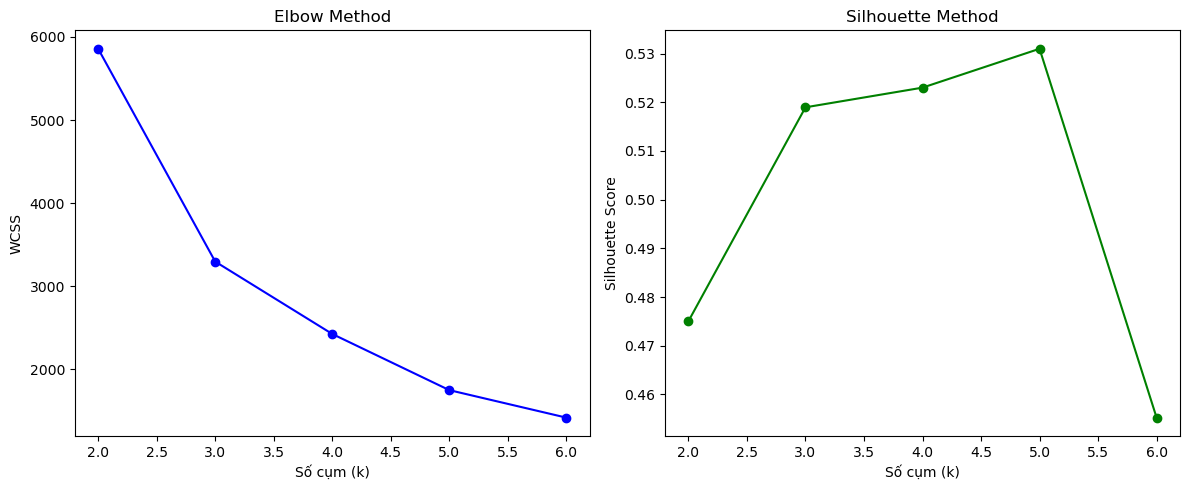

In [47]:
# Tìm số cụm tối ưu
wcss = []
silhouette_scores = []
K = range(2, 7)  # Với 5 khách hàng, thử 2-5 cụm

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)

# Vẽ biểu đồ
plt.figure(figsize=(12, 5))

# Elbow plot
plt.subplot(1, 2, 1)
plt.plot(K, wcss, 'bo-')
plt.xlabel('Số cụm (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')

# Silhouette score plot
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'go-')
plt.xlabel('Số cụm (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')

plt.tight_layout()
plt.show()

In [48]:
# In số cụm tối ưu theo Silhouette score
optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
print(f"Số cụm tối ưu theo Silhouette Score là: {optimal_k}")

Số cụm tối ưu theo Silhouette Score là: 5


In [49]:
# Sau khi đã xác định optimal_k ở bước trên
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
rfm['label'] = kmeans.fit_predict(X_scaled)


In [50]:
rfm 

,Recency,Frequency,Monetary,label
CustomerID,,,,
12346.0,163,1,77183.60,2
12347.0,21,3,1049.46,0
12348.0,86,2,469.16,1
12350.0,148,1,174.20,1
12352.0,100,5,1455.86,1
...,...,...,...,...
18273.0,95,1,51.00,1
18280.0,115,1,147.90,1
18281.0,18,1,53.79,0


In [52]:
rfm.describe()

,Recency,Frequency,Monetary,label
count,2724.000000,2724.000000,2724.000000,2724.000000
mean,59.764684,2.717327,939.536814,0.707048
std,47.913115,3.878259,3589.578865,1.118440
min,0.000000,1.000000,2.900000,0.000000
25%,20.000000,1.000000,180.550000,0.000000
50%,46.000000,2.000000,355.135000,0.000000
75%,94.000000,3.000000,761.657500,1.000000
max,177.000000,67.000000,89361.990000,4.000000


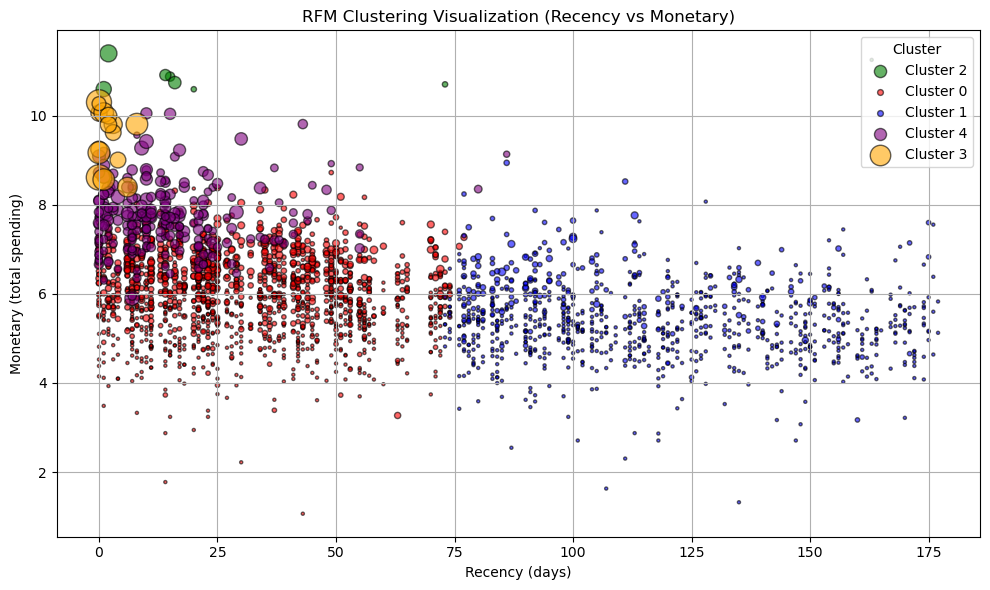

In [59]:
df = rfm 

# Ánh xạ màu sắc cho từng label (tối đa 5 cụm)
colors = ['red', 'blue', 'green', 'orange', 'purple']
unique_labels = df['label'].unique()

# Chuyển đường kính (Frequency) thành diện tích cho marker
# Area ≈ π * (d/2)^2 → scale lên để dễ nhìn
size_scale = 5  # tùy chỉnh để dễ quan sát
sizes = (df['Frequency'])**2 * size_scale

# Vẽ scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

for label in unique_labels:
    cluster = df[df['label'] == label]
    ax.scatter(
        cluster['Recency'],
        np.log(cluster['Monetary']),
        s=(cluster['Frequency']) * size_scale,
        color=colors[label % len(colors)],
        alpha=0.6,
        edgecolors='k',
        label=f'Cluster {label}'
    )

# Gán nhãn trục và tiêu đề
ax.set_xlabel('Recency (days)')
ax.set_ylabel('Monetary (total spending)')
ax.set_title('RFM Clustering Visualization (Recency vs Monetary)')
ax.legend(title='Cluster')

plt.grid(True)
plt.tight_layout()
plt.show()


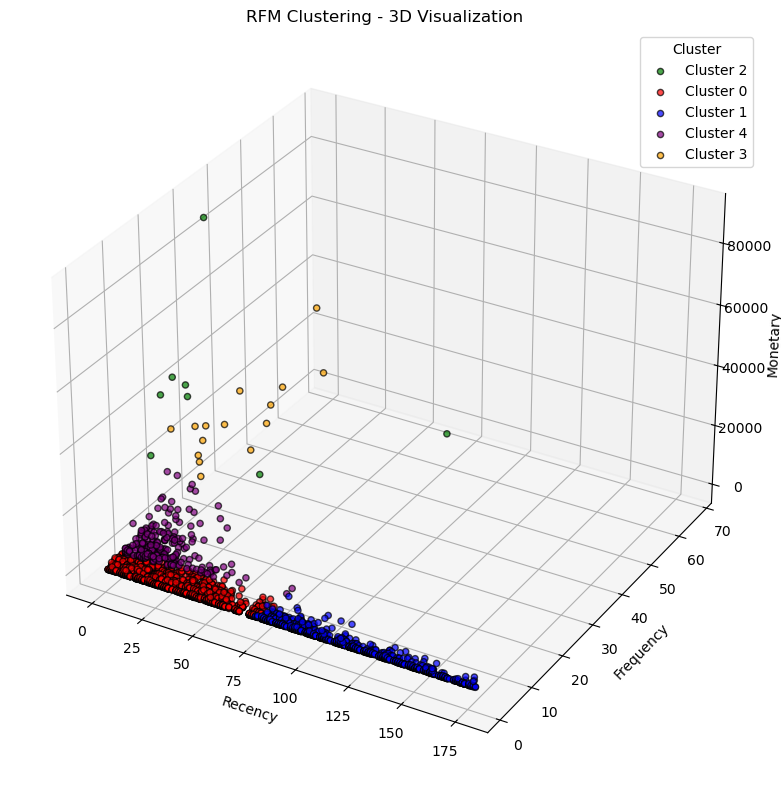

In [62]:
from mpl_toolkits.mplot3d import Axes3D

# Khởi tạo plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Màu cho từng cụm
colors = ['red', 'blue', 'green', 'orange', 'purple']
unique_labels = df['label'].unique()

# Vẽ từng cụm
for label in unique_labels:
    cluster = df[df['label'] == label]
    ax.scatter(
        cluster['Recency'],
        cluster['Frequency'],
        cluster['Monetary'],
        s= 20,  # scale cho marker to ra
        color=colors[label % len(colors)],
        alpha=0.7,
        edgecolors='k',
        label=f'Cluster {label}'
    )

# Gán nhãn trục
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('RFM Clustering - 3D Visualization')

# Thêm chú thích
ax.legend(title="Cluster")
plt.tight_layout()
plt.show()


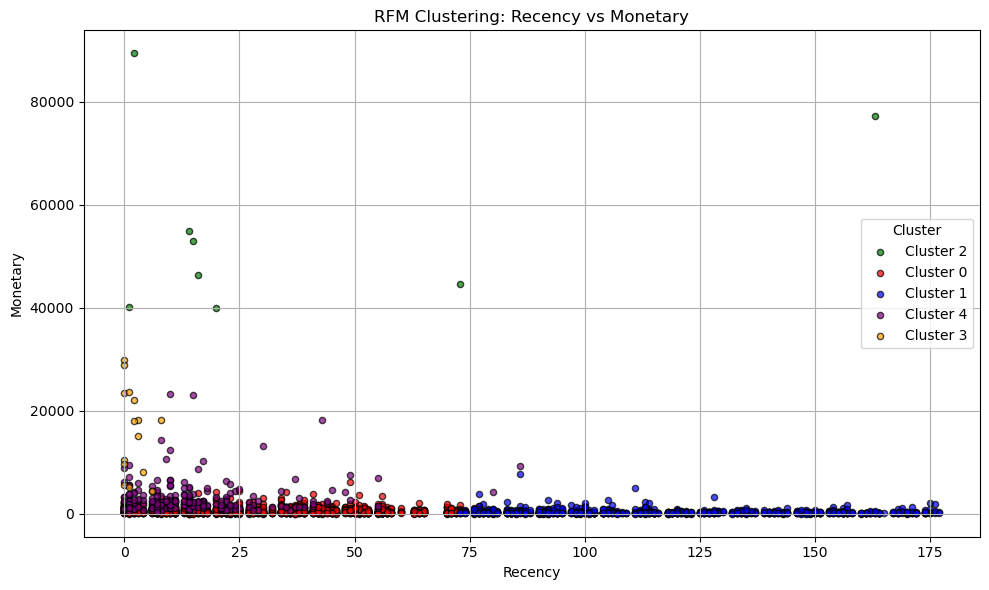

In [64]:

# Danh sách màu cho từng cụm (tối đa 5 cụm)
colors = ['red', 'blue', 'green', 'orange', 'purple']
unique_labels = df['label'].unique()

# Chọn hai trục
x_col = 'Recency'
y_col = 'Monetary'

# Vẽ scatter plot
plt.figure(figsize=(10, 6))

for label in unique_labels:
    cluster = df[df['label'] == label]
    plt.scatter(
        cluster[x_col],
        cluster[y_col],
        color=colors[label % len(colors)],
        alpha=0.7,
        edgecolors='k',
        s=20,  # kích thước marker dựa theo Frequency
        label=f'Cluster {label}'
    )

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f'RFM Clustering: {x_col} vs {y_col}')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


In [67]:
pd.pivot_table(data=rfm,
               index='label',
               columns=['Recency', 'Frequency', 'Monetary'],
               values=['Recency', 'Frequency', 'Monetary'])

label
0
1
2
3
4


In [68]:
rfm.head()

,Recency,Frequency,Monetary,label
CustomerID,,,,
12346.0,163,1,77183.60,2
12347.0,21,3,1049.46,0
12348.0,86,2,469.16,1
12350.0,148,1,174.20,1
12352.0,100,5,1455.86,1


In [69]:
rfm_grouped = df.groupby('label')[['Recency', 'Frequency', 'Monetary']].mean()

In [70]:
rfm_grouped

,Recency,Frequency,Monetary
label,,,
0,31.650000,2.250000,572.989685
1,116.450157,1.291710,326.605152
2,38.000000,12.375000,55663.646250
3,2.000000,38.466667,16036.549333
4,14.824561,9.100877,3031.762456


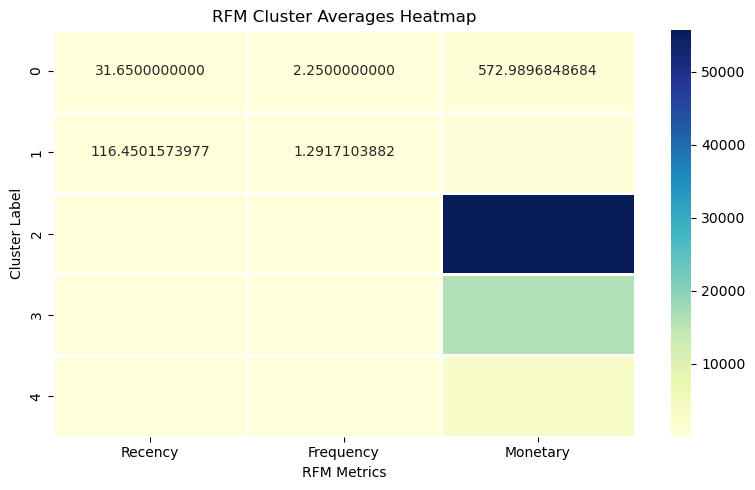

In [74]:
import seaborn as sns

# Giả sử rfm_grouped là DataFrame bạn vừa tính:
# rfm_grouped = df.groupby('label')[['Recency', 'Frequency', 'Monetary']].mean().round(2)

plt.figure(figsize=(8, 5))
sns.heatmap(rfm_grouped, annot=True, fmt=".10f", cmap="YlGnBu", linewidths=1)

plt.title("RFM Cluster Averages Heatmap")
plt.xlabel("RFM Metrics")
plt.ylabel("Cluster Label")

plt.tight_layout()
plt.show()


In [77]:
print(rfm_grouped.sort_values(by='Monetary'))

          Recency  Frequency      Monetary
label                                     
1      116.450157   1.291710    326.605152
0       31.650000   2.250000    572.989685
4       14.824561   9.100877   3031.762456
3        2.000000  38.466667  16036.549333
2       38.000000  12.375000  55663.646250
